In [1]:
import sys,os

import pyglet
pyglet.options['shadow_window'] = True

import pyrender#to display mesh
import numpy as np
import trimesh#to load mesh

import matplotlib
import matplotlib.pyplot as plt
import igl

from sklearn.neighbors import KDTree
from ICP_functions import *

%load_ext autoreload
%autoreload 2

In [2]:
make_obj_test_files(['bunny_v2/bun000_v2.obj','bunny_v2/bun045_v2.obj'])


True

In [3]:
#make noisy versions of model M2.
v2,f2 = igl.read_triangle_mesh('M2.obj')
box_scale=np.mean(np.array([(np.max(v2[:,i])-np.min(v2[:,i]))**2 for i in range(3)]))
n=40
increment=0.05

noise_levels=[]
for i in range(0,n):
    sigma = increment*i*box_scale
    noise = sigma*np.random.randn(v2.shape[0],3)
    v = v2 + noise
    f = f2
    
    igl.write_triangle_mesh("M2_noisy"+str(i)+".obj", v, f)


In [5]:
#Render noisy versions of M2.
M1_fp='M1.obj'
tm1 = trimesh.load_mesh(M1_fp)#load mesh
surface_points1 = tm1.sample(20000)#sample points for a point cloud
mesh_rd1 = pyrender.Mesh.from_points(surface_points1, colors=(0.0,0.0,1.0))#make a point cloud object

mesh_rds=[mesh_rd1]
tms=[tm1]

for i in range(0,n):
    M2_fp="M2_noisy"+str(i)+".obj"
    tm2 = trimesh.load_mesh(M2_fp)#load mesh
    surface_points2 = tm2.sample(20000)#sample points for a point cloud
    
    if i==0:
        colors=colors=(0.0,1.0,0.0)
    else:
        colors=colors=(1.0,0.0,0.0)
        
    mesh_rd2 = pyrender.Mesh.from_points(surface_points2, colors)#make a point cloud object
    mesh_rds.append(mesh_rd2)


In [6]:
#Display M1 and a noisy version of M2.
#The noiseless version of M2 is at index 1 and is coloured green. 
#The noisy versions are from index 2 to index n and they are coloured red.
show_mesh_gui([mesh_rds[0],mesh_rds[-1]])#Display original mesh and first two mesh or pointcloud.

In [13]:
P, f_P = igl.read_triangle_mesh(M1_fp)
experiment_mses=[]
iterations_used=[]
rotations=[]
translations=[]

for i in range(0,n):
    print('Processing for noisy model number '+str(i+1)+'... ',end='')
    M2_fp="M2_noisy"+str(i+1)+".obj"
    Q, f_Q = igl.read_triangle_mesh(M2_fp)
    R,t,mse_losses,iterations=ICP(P,Q)
    
    rotations.append(R)
    translations.append(t)
    experiment_mses.append(mse_losses)
    iterations_used.append(iterations)

Processing for noisy model number 1... ICP converged after 22 iterations.
Processing for noisy model number 2... ICP converged after 22 iterations.
Processing for noisy model number 3... ICP converged after 22 iterations.
Processing for noisy model number 4... ICP converged after 22 iterations.
Processing for noisy model number 5... ICP converged after 21 iterations.
Processing for noisy model number 6... ICP converged after 21 iterations.
Processing for noisy model number 7... ICP converged after 22 iterations.
Processing for noisy model number 8... ICP converged after 22 iterations.
Processing for noisy model number 9... ICP converged after 23 iterations.
Processing for noisy model number 10... ICP converged after 23 iterations.
Processing for noisy model number 11... ICP converged after 24 iterations.
Processing for noisy model number 12... ICP converged after 25 iterations.
Processing for noisy model number 13... ICP converged after 30 iterations.
Processing for noisy model number 

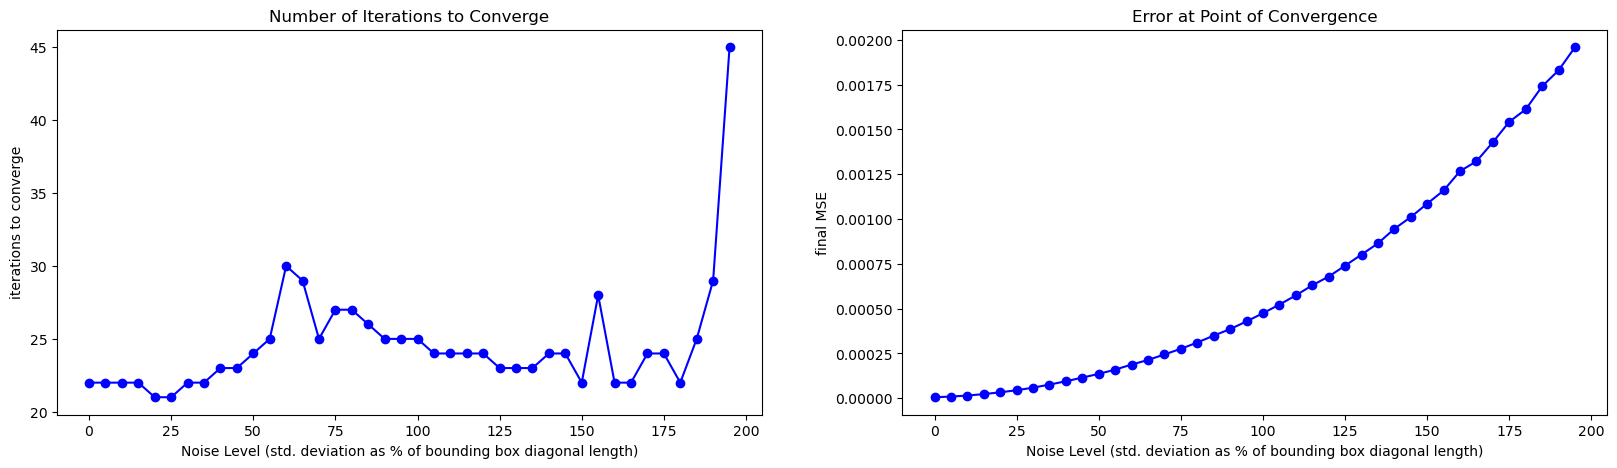

True

In [26]:
noise_levels=np.array([5*i for i in range(0,n)])#that is std. deviation of gaussian, as a % of bb diagonal length
plot_summary_data(noise_levels,experiment_mses,iterations_used,
                  'Noise Level (std. deviation as % of bounding box diagonal length)')

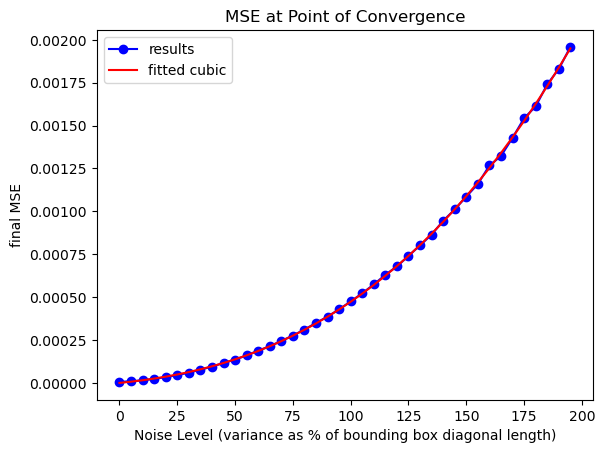

In [50]:
#additional plot
fig,ax=plt.subplots()
final_mses=[experiment_mses[i][-1] for i in range(40)]
ax.plot(noise_levels,final_mses,'bo-')

degree=3
coeffs=np.polyfit(noise_levels,final_mses,degree)
polynomial3=np.sum([coeffs[i]*noise_levels**(degree-i) for i in range(degree+1)],axis=0)
ax.plot(noise_levels,polynomial3,'r-')

ax.legend(['results','fitted cubic'])
ax.set_xlabel('Noise Level (variance as % of bounding box diagonal length)')
ax.set_ylabel('final MSE')
ax.set_title('MSE at Point of Convergence')
plt.show()

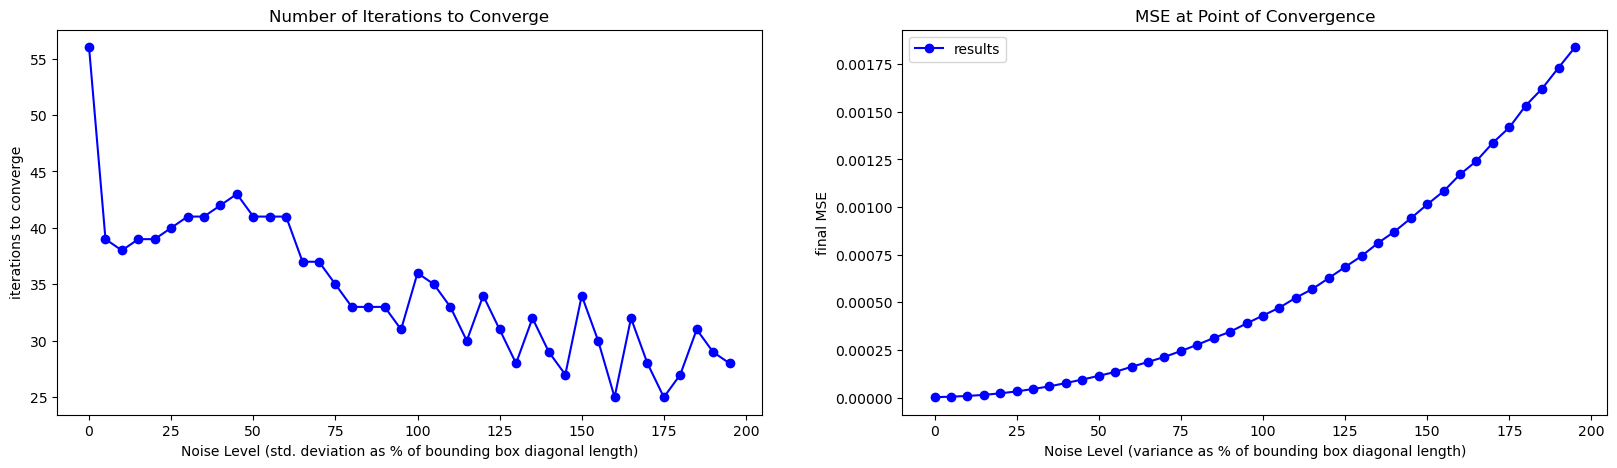

In [242]:

fig,ax=plt.subplots(1,2,figsize=(20,5))
noise_levels=np.array([5*i for i in range(0,n)])#that is std. deviation of gaussian, as a % of bb diagonal length

final_mses = [experiment_mses[i][-1] for i in range(0,n)]
ax[0].plot(noise_levels,iterations_used,'bo-')
ax[0].set_xlabel('Noise Level (std. deviation as % of bounding box diagonal length)')
ax[0].set_ylabel('iterations to converge')
ax[0].set_title('Number of Iterations to Converge')


ax[1].plot(noise_levels,final_mses,'bo-')

#degree=3
#coeffs=np.polyfit(noise_levels**2,final_mses,degree)
#polynomial3=np.sum([coeffs[i]*noise_levels**(2*i) for i in range(degree+1)],axis=0)
#ax[1].plot(noise_levels**2,polynomial3,'r-')

ax[1].legend(['results','fitted cubic'])
ax[1].set_xlabel('Noise Level (variance as % of bounding box diagonal length)')
ax[1].set_ylabel('final MSE')
ax[1].set_title('MSE at Point of Convergence')
plt.show()